In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.util.plotting_util import PlottingUtil

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from simulation_engine.util.plotting_util import PlottingUtil
pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
import re

#setup
# results = pd.read_pickle('testrun.pkl')
results = pd.read_pickle('17_06/results.pkl')
binaryIV = ContinuousIV('IV DAG', results)


                            Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
       ATE_entropybounds-0.10--binned          0.00            16.50          0.5795      0.8139          6.20
           ATE_zaffalonbounds--binned          0.00            23.35          0.6672      0.9784          7.44
                        ATE_2SLS-0.95          0.35            30.41          0.7181      1.1110          6.53
              ATE_causaloptim--binned          5.20            21.04          0.7281      1.0480          8.86
       ATE_entropybounds-0.20--binned          0.00             7.50          0.7501      0.8438          5.89
                        ATE_2SLS-0.98          0.35            26.19          0.7741      1.0984          6.69
                ATE_autobound--binned         11.40            11.17          0.7954      1.0520          7.27
                  ATE_zhangbareinboim          1.20             7.69          0.8022      0.9076          5.20
 

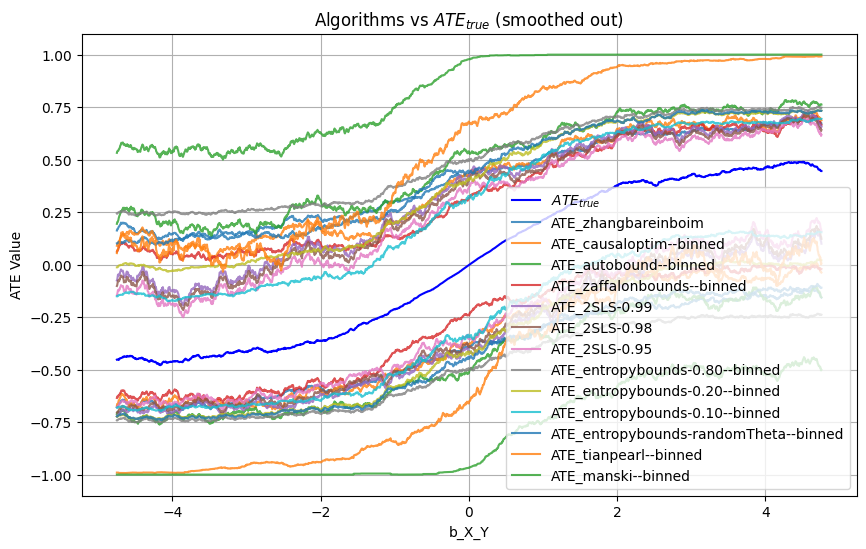

In [4]:
#ATE Evaluation
df = results
algorithm_names = PlottingUtil.extract_algorithm_names(df, 'ATE')
PlottingUtil.print_bound_statistics_table(df, algorithm_names, 'ATE')
PlottingUtil.plot_smoothed_query_vs_bounds(df, 'ATE', algorithm_names, 100)

             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
           PNS_nonpara          0.00            27.55          0.1915      0.4142
    PNS_zaffalonbounds          0.00             1.50          0.3918      0.4009
       PNS_causaloptim          4.50            11.47          0.4106      0.5017
         PNS_autobound          1.20             1.47          0.4279      0.4431
PNS_entropybounds-0.10          0.00             0.25          0.5024      0.5036
PNS_entropybounds-0.20          0.00             0.10          0.5771      0.5775
PNS_entropybounds-0.80          0.00             0.10          0.7126      0.7129


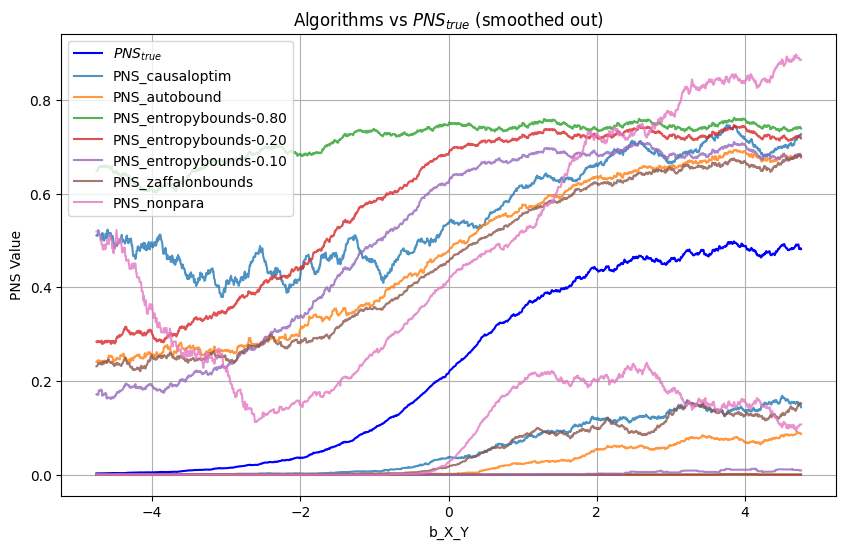

In [5]:
#PNS Evaluation
PlottingUtil.print_bound_statistics_table(results, algs, 'PNS')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'PNS', PNS_algs, 100)

ATE algorithms: ['2SLS-0.99', '2SLS-0.98', 'causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']


d:\TUM Workspace\Thesis Workspace\causal-bounds\binaryIV\..\simulation_engine\util\plotting_util.py:233: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha='right')


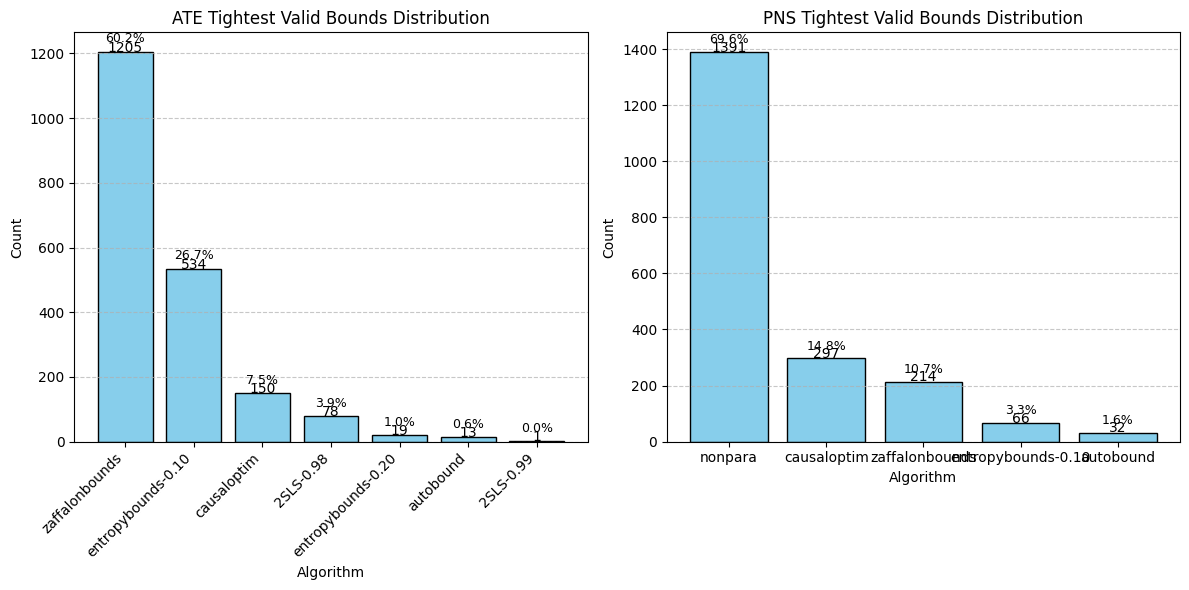

In [38]:
df = results.copy()
# Find tightest bounds without requiring bounds to be valid
tb = PlottingUtil.compute_tightest_bound_valid(df)
PlottingUtil.plot_tightest_bounds_distribution(tb, 'true')
